# About the task:
In this notebook we are creating a model that, given a medical note, tries to predict if and which other organs are involved. The task and the model are substantially the same as the previous one in `class_infection_source.ipynb`.






# Imports

In [7]:
import pandas as pd
import numpy as np
import json
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score, roc_auc_score
import os
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Preprocessing

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
# filling nan values
df = pd.read_csv('KINBIOTICS_CLASSIFICATION.csv')
df['other_organs'] = df['other_organs'].fillna('None of the above')

In [10]:
# binarizing each label to create a multilabel dataset
labels_list = ['Abdominal', 'Gastrointestinal', 'Bile duct', 'Urosepsis', 'Catheter-associated', 'Endocarditis',
        'Skin and soft tissue', 'Bone and joints', 'Neurological', 'Respiratory', 'Non-identifiable']

# Initialize a dictionary to store data for the new DataFrame
df_other = {
    'text': []  # List to store 'text' column data
}

# Loop through the 'labels_list' list and add empty lists for each label in the dictionary
for label in labels_list:
    df_other[label] = []

# Iterate through each row in the original DataFrame 'df'
for _, row in df.iterrows():
    # Check if the value in the 'other_organs' column is not 'None of the above'
    if row['other_organs'] != 'None of the above':
        # Append 'text' data to the 'text' list in the dictionary
        df_other['text'].append(row['text'])

        # Check if 'choices' is a key in the 'other_organs' value
        if 'choices' in row['other_organs']:
            # Loop through each label in the 'labels_list' list
            for label in labels_list:
                # Check if the current label is in the 'choices' list
                if label in json.loads(row['other_organs'])['choices']:
                    df_other[label].append(1)  # If present, append 1 to the list
                else:
                    df_other[label].append(0)  # If not present, append 0 to the list
        else:
            # Loop through each label in the 'labels_list' list
            for label in labels_list:
                # Check if the current label is equal to the 'other_organs' value
                if label == row['other_organs']:
                    df_other[label].append(1)  # If equal, append 1 to the list
                else:
                    df_other[label].append(0)  # If not equal, append 0 to the list
    else:
        continue  # If 'other_organs' is 'None of the above', skip to the next iteration

# Create a new DataFrame 'df_other' from the dictionary
df_other = pd.DataFrame(df_other)




In [11]:
df_other

,text,Abdominal,Gastrointestinal,Bile duct,Urosepsis,Catheter-associated,Endocarditis,Skin and soft tissue,Bone and joints,Neurological,Respiratory,Non-identifiable
0,Chief Complaint:\n s/p falls\n\nHistory of Pre...,0,0,0,0,0,0,1,0,0,0,0
1,Chief Complaint:\n febrile and neutropenia\n\n...,0,0,0,1,0,0,0,0,0,1,0
2,Chief Complaint:\n septic shock\n\nHistory of ...,1,0,0,0,0,0,0,0,0,1,0
3,Chief Complaint:\n hepatic failure\n\nHistory ...,0,1,1,1,0,0,0,0,0,0,0
4,Chief Complaint:\n ruq pain\n\nHistory of Pres...,0,0,0,1,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
253,Chief Complaint:\n shortness of breath\n\nHist...,0,0,1,0,0,1,0,0,1,0,0
254,"Chief Complaint:\n fever, hypotension\n\nHisto...",0,0,1,1,1,1,1,1,0,0,0
255,Chief Complaint:\n abdominal pain\n\nHistory o...,0,1,0,0,0,1,0,0,0,1,0
256,"Chief Complaint:\n hypoxemia, confusion\n\nHis...",1,0,0,0,0,0,0,0,0,0,0


In [12]:
texts= df_other['text']
labs = []

for _, row in df_other.iterrows():
    lab = []
    for label in labels_list:
        lab.append(row[label])
    labs.append(lab)

In [13]:

# Tokenize and preprocess the data
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokenized_data = tokenizer.batch_encode_plus(texts, padding=True, truncation=True, return_tensors='pt')

# Create DataLoader
dataset = TensorDataset(
    tokenized_data['input_ids'],
    tokenized_data['attention_mask'],
    torch.tensor(labs, dtype=torch.float32)
)

train_dataset, val_dataset = train_test_split(dataset, test_size=0.2, random_state=42)

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [14]:
# Load pre-trained BERT model
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=len(labs[0])
)

# Define optimizer and loss function
optimizer = AdamW(model.parameters(), lr=2e-5)
loss_fn = torch.nn.BCEWithLogitsLoss()

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [15]:
def predict(model, dataloader):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(torch.sigmoid(logits).cpu().numpy())

    return all_labels, all_preds

In [16]:
# Training
f1s_val = []
f1s_train = []

print('=========== TRAINING STARTS ===========')
print('---------------------------------------')
print('| EPOCH | AVG LOSS | MICRO F1 |  AUC  |')
print('---------------------------------------')
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch in train_dataloader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    average_loss = total_loss / len(train_dataloader)

    # Validation
    val_labels, val_preds = predict(model, val_dataloader)

    train_labels, train_preds = predict(model, train_dataloader)

    # Calculate F1 score
    f1_val = f1_score(val_labels, (np.array(val_preds) > 0.5).astype(int), average='micro')
    f1_train = f1_score(train_labels, (np.array(train_preds) > 0.5).astype(int), average='micro')

    f1s_val.append(f1_val)
    f1s_train.append(f1_train)

    # Calculate ROC AUC score
    roc_auc = roc_auc_score(val_labels, np.array(val_preds), multi_class='ovr', average='micro')

    # Adjusted print statement for better alignment
    print(f'| {epoch + 1: <5} | {round(average_loss, 3): <8} | {round(f1_val, 3): <8} | {round(roc_auc, 3): <5} |')


print('========== TRAINING COMPLETED =========')


=========== TRAINING STARTS ===========
---------------------------------------
| EPOCH | AVG LOSS | MICRO F1 |  AUC  |
---------------------------------------
| 1     | 0.583    | 0.261    | 0.665 |
| 2     | 0.494    | 0.204    | 0.744 |
| 3     | 0.458    | 0.273    | 0.751 |
| 4     | 0.452    | 0.262    | 0.748 |
| 5     | 0.448    | 0.273    | 0.744 |
| 6     | 0.445    | 0.205    | 0.759 |
| 7     | 0.441    | 0.171    | 0.766 |
| 8     | 0.43     | 0.309    | 0.775 |
| 9     | 0.417    | 0.245    | 0.765 |
| 10    | 0.395    | 0.183    | 0.77  |
| 11    | 0.383    | 0.311    | 0.774 |
| 12    | 0.359    | 0.337    | 0.776 |
| 13    | 0.337    | 0.248    | 0.779 |
| 14    | 0.317    | 0.289    | 0.782 |
| 15    | 0.298    | 0.32     | 0.779 |
| 16    | 0.278    | 0.377    | 0.776 |
| 17    | 0.261    | 0.313    | 0.775 |
| 18    | 0.244    | 0.313    | 0.768 |
| 19    | 0.223    | 0.313    | 0.779 |
| 20    | 0.204    | 0.286    | 0.773 |
| 21    | 0.19     | 0.306    | 0.756 |


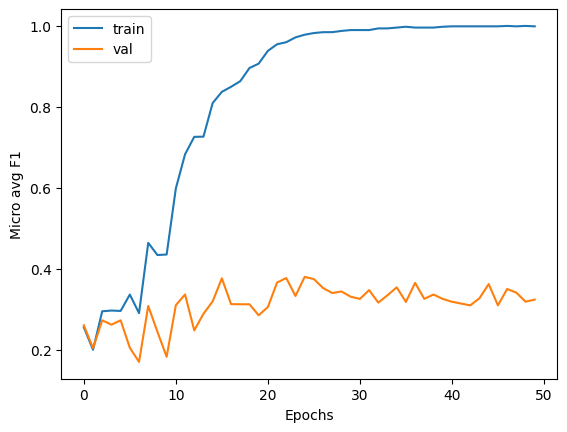

In [17]:
plt.xlabel('Epochs')
plt.ylabel('Micro avg F1')
plt.plot(list(range(50)), f1s_train, label='train')
plt.plot(list(range(50)), f1s_val, label='val')
plt.legend()
plt.show()

From the graph above we can see how after 10 epochs the improvement on the on validation dataset continue to increase but extremely slowly. Continue to training with the current setting may not be a good idea because the model starts to overfit.



In [18]:
# Evaluation
model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for batch in val_dataloader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        predictions = torch.sigmoid(outputs.logits)
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert predictions to binary format
binary_predictions = (np.array(all_predictions) > 0.5).astype(int)

# Evaluate performance
print("Classification Report:")
print(classification_report(all_labels, binary_predictions, zero_division=1))


Classification Report:
              precision    recall  f1-score   support

           0       0.29      0.44      0.35         9
           1       0.38      0.23      0.29        13
           2       0.00      0.00      0.00        13
           3       0.57      0.38      0.46        21
           4       1.00      0.00      0.00         1
           5       0.17      0.09      0.12        11
           6       0.50      0.07      0.12        14
           7       1.00      0.00      0.00         3
           8       1.00      0.00      0.00         2
           9       0.43      0.59      0.50        22
          10       1.00      1.00      1.00         0

   micro avg       0.39      0.28      0.32       109
   macro avg       0.58      0.26      0.26       109
weighted avg       0.40      0.28      0.28       109
 samples avg       0.53      0.32      0.33       109



For what concerns model's performances, we can maje a similar discussion as in `class_infection_source.ipynb`. Performances are still better than a random guesser, but not very exciting. It's interesting to note how the model performed worse than the previous model, despite the task being almost the same. It looks like it wasn't able to find as many meaningful patterns on the data as the other model did.

# Application on unlabeled dataset

In [20]:
folder_path= '/content/drive/MyDrive/processed/processed'

results= {
    'text':[],
    'sources': []


}

for file_name in os.listdir(folder_path):
    file_path = os.path.join(folder_path, file_name)

    with open (file_path, 'r') as file:

        new_text = file.read()
        results['text'].append(new_text)


        tokenized_new_text = tokenizer.encode_plus(new_text, padding=True, truncation=True, return_tensors='pt')

        model.eval()
        with torch.no_grad():
            input_ids = tokenized_new_text['input_ids'].to(device)
            attention_mask = tokenized_new_text['attention_mask'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            predictions = torch.sigmoid(outputs.logits)

        threshold = 0.5
        binary_prediction = (predictions > threshold).int().cpu().numpy()

        text_labels=[labels_list[i] for i, value in enumerate(binary_predictions[0]) if value == 1]

        if len(text_labels)==0:
          text_labels.append('Non-identifiable')

        results['sources'].append(text_labels)



In [21]:
rpd = pd.DataFrame(results)

In [22]:
rpd.to_csv('MIMIC_other_organs.csv')